<a href="https://colab.research.google.com/github/marchaem/causal-inference/blob/master/DoWhy_causal_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=Darkred>Causal inference in observational data</font>
---


## <font color=Darkblue>Identifying the impact of a training program on earnings.  </font>

> Dehejia and Wahba (1999). __Causal Effects in Non-Experimental Studies: Reevaluating the Evaluation of Training Programs__, _Journal of the American Statistical Association_, Vol. 94, No. 448 (December 1999), pp. 1053-1062. [Data info](https://users.nber.org/~rdehejia/data/.nswdata2.html)

<br>

Install `graphviz` (AT&T Labs Research) and its Python interface `pygraphviz` for graph layout and visualization.

We're going to use [DoWhy](https://www.microsoft.com/en-us/research/blog/dowhy-a-library-for-causal-inference/) (Microsoft) as the causal inference package.


In [0]:
!sudo apt install graphviz libgraphviz-dev graphviz-dev pkg-config
!pip install pygraphviz --install-option="--include-path=/usr/include/graphviz" --install-option="--library-path=/usr/lib/graphviz/"
!pip install dowhy 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 28 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://a

After this step, restart the runtime: __Runtime -> Restart runtime...__

<br>

Also, install the other required packages.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm

<br>

### <font color=Darkred>1. The dataset</font>

* The treated sample is one of 185 males who received training during 1976–1977. 
<br>
* The control group consists of 2,490 male household heads under the age of 55 who are
not retired.

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving DW1999.csv to DW1999.csv
User uploaded file "DW1999.csv" with length 115535 bytes


In [3]:
df=pd.read_csv('DW1999.csv', delimiter=',')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (2675, 10)


,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,1,37,11,1,0,1,1,0.0,0.0,9930.04590
1,1,22,9,0,1,0,1,0.0,0.0,3595.89400
2,1,30,12,1,0,0,0,0.0,0.0,24909.44900
3,1,27,11,1,0,0,1,0.0,0.0,7506.14600
4,1,33,8,1,0,0,1,0.0,0.0,289.78989


The dataset should contain 10 variables and 2675 cases, matching the 185 (treatment) + 2490 (control) presented in the original study.

<br>

### <font color=Darkred>2. Descriptive analysis</font>

#### <font color=Darkred>2.1 Summary statistics</font>


In [4]:
df.describe().round(2).T      # .T = transposed
# To get stats by study group, add groupby('treat')

,count,mean,std,min,25%,50%,75%,max
treat,2675.0,0.07,0.25,0.0,0.00,0.00,0.00,1.00
age,2675.0,34.23,10.50,17.0,25.00,32.00,43.50,55.00
education,2675.0,11.99,3.05,0.0,10.00,12.00,14.00,17.00
black,2675.0,0.29,0.45,0.0,0.00,0.00,1.00,1.00
hispanic,2675.0,0.03,0.18,0.0,0.00,0.00,0.00,1.00
married,2675.0,0.82,0.38,0.0,1.00,1.00,1.00,1.00
nodegree,2675.0,0.33,0.47,0.0,0.00,0.00,1.00,1.00
re74,2675.0,18230.00,13722.25,0.0,8816.70,17437.47,25470.47,137148.69
re75,2675.0,17850.89,13877.78,0.0,7605.29,17008.06,25583.71,156653.23
re78,2675.0,20502.38,15632.52,0.0,9243.40,19432.10,28815.67,121173.58


<br> 
Let's build a histogram to inspect the distribution of cases by study group.
<br>
Let's use [`matplotlib`](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Matplotlib_Cheat_Sheet.pdf) and [`seaborn`](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Seaborn_Cheat_Sheet.pdf). 

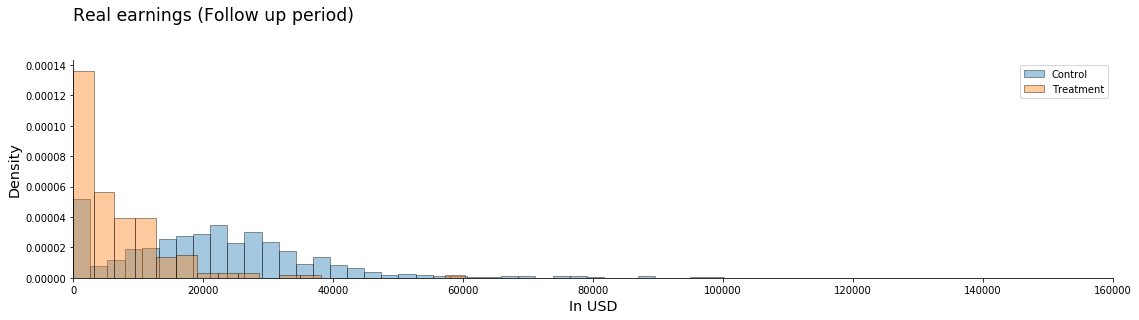

In [5]:
# Step 1 - prepare the data for the plot
treatdf = df[df['treat'].isin(['1']) ]
controldf = df[df['treat'].isin(['0']) ]

# Step 2 - initialize plot
plt.figure(figsize=(41,4))

# Step 3 - Plots
plt.subplot(1,2,1)
sns.distplot(controldf['re78'], kde = False, norm_hist = True, 
             hist_kws=dict(edgecolor="k", linewidth=1))
sns.distplot(treatdf['re78'], kde = False, norm_hist = True,
             hist_kws=dict(edgecolor="k", linewidth=1)) # To show Frequency, norm_hist = False 
sns.despine(top=True, right=True, left=False, bottom=False)

# Further customize
plt.xlabel('In USD', size = 'x-large')
plt.xlim(0, 160000)
plt.ylabel('Density', size = 'x-large') 
plt.title('Real earnings (Follow up period)', loc = "left", size = 'xx-large', pad = 40)
plt.legend(labels=['Control','Treatment']);


<br>

#### <font color=Darkred>2.1 Comparative stats for earnings</font>




<br>

> __2.1.1. Follow-up period: Treatment group _versus_ Control group__

One possible measure of the effect of training is the difference in earnings in the follow-up period between the treated and the control groups. This leads to the estimate __6,349 − 21,554 =__ <font color=Darkred>__−15,205__</font>. 
<br><br> 
This is
called a __treatment–control comparison__ estimator as it mimics the analysis in an
experimental setting.

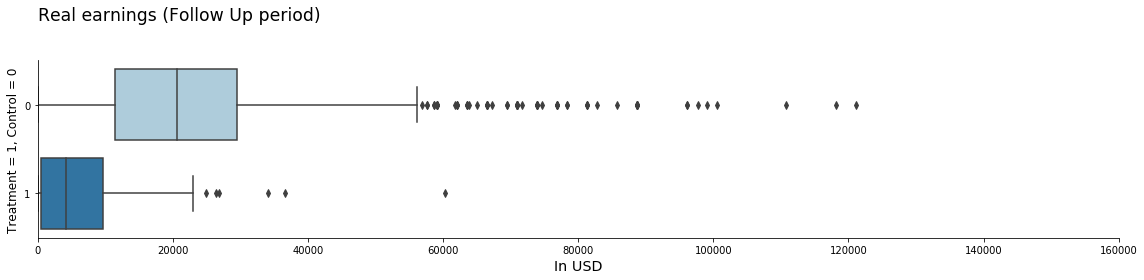

In [6]:
sns.catplot(x="re78", y="treat",
                   kind="box", orient = "h", 
                   height=4, aspect=4,
                   data=df,
                   palette = "Paired") # To show the mean, add showmeans=True

plt.xlabel('In USD', size = 'x-large')
plt.xlim(0, 160000)
plt.ylabel('Treatment = 1, Control = 0', size = 'large')
plt.title('Real earnings (Follow Up period)', loc = "left", 
          size = 'xx-large', pad = 40)
plt.tight_layout();

<br>

>__2.1.2. Treatment group: Baseline _versus_ Follow-up period__

A second approach is a before–after comparison, which looks at the change between baseline and follow-up earnings. Using mean earnings for the treated group leads to the difference estimate __6,349 − 1,532 =__ <font color=Darkblue>__4,817__</font>.
<br><br>
This estimate may be misleading as it reflects all changes over this time period, such as an improved economy, and not just training.

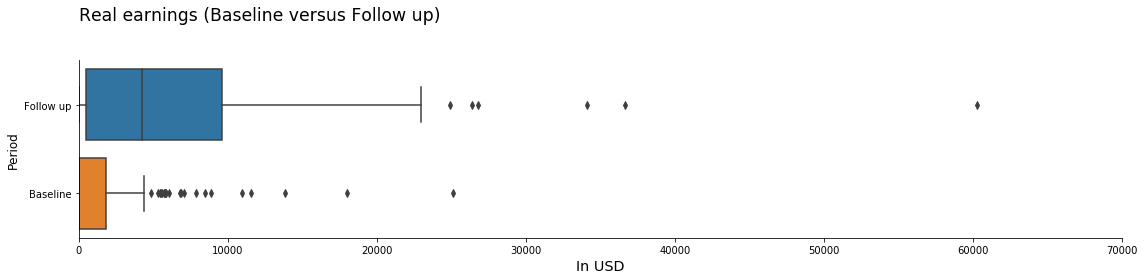

In [7]:
plt.figure(figsize=(16,4))

data1=df.loc[df['treat'] == 1]
data1=data1[['re78','re75']]
data1.columns = ['Follow up','Baseline']

sns.boxplot(data=data1, orient="h") # To show the mean, add showmeans=True
plt.xlabel('In USD', size = 'x-large')
plt.xlim(0, 70000)
plt.ylabel('Period', size = 'large')
plt.title('Real earnings (Baseline versus Follow up)', loc = "left", size = 'xx-large', pad = 40)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout();

# data1.describe()

<br>

### <font color=Darkred>3. Causal inference</font>

<br>

#### <font color=Darkred>3.1 Difference in differences estimation</font>

In [8]:
df['d_earnings'] = df['re78'] - df['re75']  # d_earnings is the change in earning 'before-after'.
df['age2'] = df['age']*df['age']
df.head()


,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,d_earnings,age2
0,1,37,11,1,0,1,1,0.0,0.0,9930.04590,9930.04590,1369
1,1,22,9,0,1,0,1,0.0,0.0,3595.89400,3595.89400,484
2,1,30,12,1,0,0,0,0.0,0.0,24909.44900,24909.44900,900
3,1,27,11,1,0,0,1,0.0,0.0,7506.14600,7506.14600,729
4,1,33,8,1,0,0,1,0.0,0.0,289.78989,289.78989,1089


In [9]:
# Estimate the DID estimate using the statsmodel package (5 lines of code)

y = df[['d_earnings']]
X = df[['treat','age','age2','education','black',
                       'hispanic','married','nodegree',
                       're74']]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:             d_earnings   R-squared (uncentered):                   0.091
Model:                            OLS   Adj. R-squared (uncentered):              0.088
Method:                 Least Squares   F-statistic:                              29.60
Date:                Wed, 23 Oct 2019   Prob (F-statistic):                    1.29e-49
Time:                        09:36:30   Log-Likelihood:                         -28565.
No. Observations:                2675   AIC:                                  5.715e+04
Df Residuals:                    2666   BIC:                                  5.720e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The treatment effect is the value of the coefficient associated to __'treat'= 1,507.44__.

<br>

#### <font color=Darkred>3.2 Estimation using DoWhy</font>

<br>

Microsoft’s [DoWhy](https://github.com/Microsoft/dowhy) is a Python-based library for __causal inference__. 

<br>

To accomplish its goal, DoWhy models any causal inference problem in a workflow with four fundamental steps: 

* 1. __Model__: models each problem using a graph of causal relationships.
* 2. __Identification strategy__: using the input graph, it finds all possible ways of identifying a desired causal effect based on the graphical model.
* 3. __Estimation__: estimates the causal effect using statistical methods such propensity-based-stratification or propensity-score-matching that focus on estimating the treatment assignmente.
* 4. __Verify__: uses different robustness methods to verify the validity of the causal effect.

In [0]:
import dowhy
from dowhy.do_why import CausalModel
from IPython.display import Image, display

In [11]:
# Create a causal model from the data and given graph
model=CausalModel(
        data = df,
        treatment='treat',
        outcome='d_earnings',
        common_causes=['age','age2', 'education','black',
                       'hispanic','married','nodegree',
                       're74'])
                  

INFO:dowhy.do_why:Model to find the causal effect of treatment ['treat'] on outcome ['d_earnings']


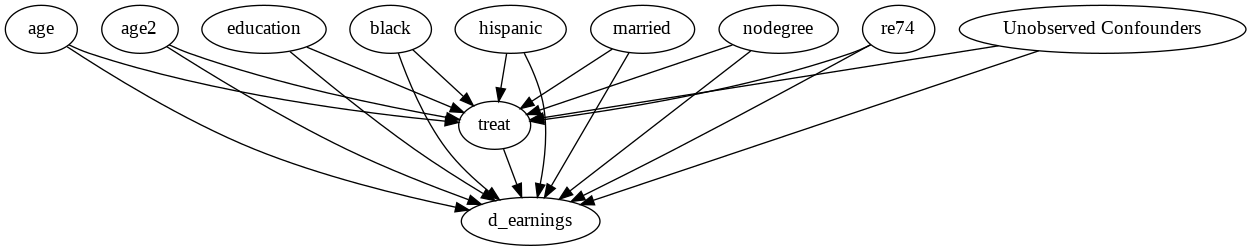

In [12]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [13]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['nodegree', 're74', 'married', 'age2', 'hispanic', 'black', 'education', 'age', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


<br>

>__3.2.1. Linear regression estimation__

In [14]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True
        )                                  
print(causal_estimate_reg)
print("The OLS regression with controls estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: d_earnings~treat+nodegree+re74+married+age2+hispanic+black+education+age


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                           
──────(Expectation(d_earnings|nodegree,re74,married,age2,hispanic,black,educat
dtreat                                                                        

         
ion,age))
         
Estimand assumption 1, Unconfoundedness: If U→treat and U→d_earnings then P(d_earnings|treat,nodegree,re74,married,age2,hispanic,black,education,age,U) = P(d_earnings|treat,nodegree,re74,married,age2,hispanic,black,education,age)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: d_earnings~treat+nodegree+re74+married+age2+hispanic+black+education+age
## Estimate
Value: 1551.7613918945194

## Statistical Significance
p-value: 0.06599999999999995

The OLS regression with controls estimate is 1551.7613918945194


<br>

>__3.2.2. Propensity score stratification__

In [15]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate_strat)
print("The stratification estimate is " + str(causal_estimate_strat.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: d_earnings~treat+nodegree+re74+married+age2+hispanic+black+education+age


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                           
──────(Expectation(d_earnings|nodegree,re74,married,age2,hispanic,black,educat
dtreat                                                                        

         
ion,age))
         
Estimand assumption 1, Unconfoundedness: If U→treat and U→d_earnings then P(d_earnings|treat,nodegree,re74,married,age2,hispanic,black,education,age,U) = P(d_earnings|treat,nodegree,re74,married,age2,hispanic,black,education,age)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: d_earnings~treat+nodegree+re74+married+age2+hispanic+black+education+age
## Estimate
Value: 2537.7162077013513

The stratification estimate is 2537.7162077013513


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<br>

>__3.2.3. Propensity score matching__

In [16]:
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate_match)
print("The matching estimate is" + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: d_earnings~treat+nodegree+re74+married+age2+hispanic+black+education+age
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                           
──────(Expectation(d_earnings|nodegree,re74,married,age2,hispanic,black,educat
dtreat                                                                        

         
ion,age))
         
Estimand assumption 1, Unconfoundedness: If U→treat and U→d_earnings then P(d_earnings|treat,nodegree,re74,married,age2,hispanic,black,education,age,U) = P(d_earnings|treat,nodegree,re74,married,age2,hispanic,black,education,age)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: d_earnings~treat+nodegree+re74+married+age2+hispanic+black+education+age
## Estimate
Value: 2910.516851070273

The matching estimate is2910.516851070273


<br>

#### <font color=Darkred>3.3 Robustness checks</font>

>__3.3.1. Data subset refuter__
Dropping a random portion of data to see how sensitive


In [17]:
res_subset=model.refute_estimate(identified_estimand, causal_estimate_match,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: d_earnings~treat+nodegree+re74+married+age2+hispanic+black+education+age


Refute: Use a subset of data
Estimated effect:(2910.516851070273,)
New effect:(2916.524780842107,)



>__3.3.2. Adding a random common cause__
adds a random common cause, a noise 

In [18]:
refute_results=model.refute_estimate(identified_estimand, causal_estimate_match,
        method_name="random_common_cause")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: d_earnings~treat+nodegree+re74+married+age2+hispanic+black+education+age+w_random
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Refute: Add a Random Common Cause
Estimated effect:(2910.516851070273,)
New effect:(2749.201014799997,)



>__3.3.3. Placebo test__
treatment variable is substituted with a random placebo, has to be zero or negative, because placebo shouldnt have any impact

In [19]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_match,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: d_earnings~placebo+nodegree+re74+married+age2+hispanic+black+education+age


Refute: Use a Placebo Treatment
Estimated effect:(2910.516851070273,)
New effect:(-626.9231766486486,)



<br>

### <font color=Darkred>4. Discussion of the results</font>

#### <font color=Darkred>4.1 Comparison with experimental and observational results</font>

> * The estimates from observational estimates often differ significantly from the experimental results, which were around 900 dollars (see [Lalonde, 1986, p.609](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)). 
* This study concluded that many of the procedures used to evaluate employment and training programs would not have yielded accurate or precise estimates of the impact of the training program. 
* Moreover, even when these estimates pass conventional specification tests, they still fail to replicate the experimentally determined
results.

> * Later on, [Dehejia and Wahba (2002)](https://nyuscholars.nyu.edu/en/publications/propensity-score-matching-methods-for-nonexperimental-causal-stud) showed that matching methods are a useful addition and complement to the standard techniques. 
* They help to build convincing counterfactuals because they construct a suitable control group in non-experimental settings.

> * Using packages like DoWhy speeds up the process of finding convincing countefactuals by testing different identification strategies and estimation processes.
* There are other similar packages like [`causalinference`](http://causalinferenceinpython.org/) [(Wong, 2016)](http://causalinferenceinpython.org/) and [`causalml`](https://github.com/uber/causalml) [Uber Engineering, 2019](https://eng.uber.com/causal-inference-at-uber/).